In [1]:
#Importar librerías
import pandas as pd
import os
import zipfile
import shutil
import requests
import zipfile
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import PercentFormatter

In [2]:
#Definir directorio de trabajo
#Directorio de trabajo. Si existe directorio D:/, se selecciona si no, C:/
try:
    os.chdir('D:/github/proyecto_infotec')
except:
    os.chdir('C:/users/claudio.pacheco/Documents/Github/proyecto_infotec')
#if os.path.exists('D:/'):
#    os.chdir('D:/github/proyecto_infotec')
#else:
#    os.chdir('C:/users/claudio.pacheco/Documents/Github/proyecto_infotec')

In [3]:
#crear directorio de salida
if not os.path.exists('datos'):
    os.makedirs('datos')

In [4]:
#Pegar todos los archivos csv en una sola data frame
df=pd.DataFrame()
for entidad in range(1,33):
    if entidad<10:
        df_temp=pd.read_csv("datos/conjunto_de_datos_ageb_urbana_"+"0"+str(entidad)+"_cpv2020.csv",encoding='utf-8', low_memory=False)
    else:
        df_temp=pd.read_csv("datos/conjunto_de_datos_ageb_urbana_"+str(entidad)+"_cpv2020.csv",encoding='utf-8', low_memory=False)
    df=pd.concat([df,df_temp],axis=0)
    print("Se ha agregado la entidad "+str(entidad)," a la dataframe")

#Imprimir el número de registros con separadores de miles
print("Se concluyó la concatenación. El conjunto de datos cuenta con "+str(df.shape[1])+" columnas y "+str("{:,}".format(df.shape[0]))+" registros")
df.columns=df.columns.str.lower()  

Se ha agregado la entidad 1  a la dataframe
Se ha agregado la entidad 2  a la dataframe
Se ha agregado la entidad 3  a la dataframe
Se ha agregado la entidad 4  a la dataframe
Se ha agregado la entidad 5  a la dataframe
Se ha agregado la entidad 6  a la dataframe
Se ha agregado la entidad 7  a la dataframe
Se ha agregado la entidad 8  a la dataframe
Se ha agregado la entidad 9  a la dataframe
Se ha agregado la entidad 10  a la dataframe
Se ha agregado la entidad 11  a la dataframe
Se ha agregado la entidad 12  a la dataframe
Se ha agregado la entidad 13  a la dataframe
Se ha agregado la entidad 14  a la dataframe
Se ha agregado la entidad 15  a la dataframe
Se ha agregado la entidad 16  a la dataframe
Se ha agregado la entidad 17  a la dataframe
Se ha agregado la entidad 18  a la dataframe
Se ha agregado la entidad 19  a la dataframe
Se ha agregado la entidad 20  a la dataframe
Se ha agregado la entidad 21  a la dataframe
Se ha agregado la entidad 22  a la dataframe
Se ha agregado la e

In [5]:
#Copia de la base original
df_limpia=df.copy()

### Procesamiento de información

In [6]:
#Se filtran por las columnas con datos de vivienda
df_limpia= df_limpia.iloc[:, list(range(8)) + list(range(177, len(df_limpia.columns)))]
print("El conjunto de datos cuenta con "+str(df_limpia.shape[1])+" columnas y "+str("{:,}".format(df_limpia.shape[0]))+" registros")

El conjunto de datos cuenta con 61 columnas y 1,683,504 registros


In [7]:
#Crear clave geoestadística
df_limpia['cvegeo'] = df_limpia['entidad'].astype(str).str.zfill(2) + df_limpia['mun'].astype(str).str.zfill(3) + df_limpia['loc'].astype(str).str.zfill(4) + df_limpia['ageb'].astype(str).str.zfill(4) + df_limpia['mza'].astype(str).str.zfill(3)

In [8]:
#Eliminar agregados de entidad. 
df_limpia=df_limpia[df_limpia['mun']!=0]
#Eliminar agregados de municipio. 
df_limpia=df_limpia[df_limpia['loc']!=0]
#Eliminar agregados de localidad.
df_limpia=df_limpia[df_limpia['ageb']!='0000']
#Eliminar agregados de manzana.
df_limpia=df_limpia[df_limpia['mza']!=0]

In [9]:
#transformar variables de la 8 en adelante a numéricas
df_limpia.iloc[:,8:]=df_limpia.iloc[:,8:].apply(pd.to_numeric, errors='coerce')

C:\Users\claud\AppData\Local\Temp\ipykernel_27264\541626342.py:2: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_limpia.iloc[:,8:]=df_limpia.iloc[:,8:].apply(pd.to_numeric, errors='coerce')


In [10]:
#Eliminar nans y ceros de la variable de viviendas particulares habitadas
df_limpia=df_limpia[df_limpia['tvivparhab']!=0]
df_limpia=df_limpia[df_limpia['tvivparhab'].notna()]
#Transformar nans a ceros
df_limpia=df_limpia.fillna(0)

In [11]:
#Cálculo de indicadores para aproximar el rezago habitacional
#1. Porcentaje de viviendas particulares habitadas que no disponen de excusado o sanitario
df_limpia['p_viv_snexc']=df_limpia['vph_letr']/df_limpia['tvivparhab']*100
#2. Porcentaje de viviendas particulares habitadas cn pisos de tierra
df_limpia['p_viv_ptierra']=(df_limpia['vph_pisoti'])/df_limpia['tvivparhab']*100
#3. Porcentaje de viviendas particulares habitadas cuyos habitantes se encuentran en hacinamiento
#Se asume que las viviendas con un solo cuarto están en hacinamiento
df_limpia['p_viv_hacina']=df_limpia['vph_1cuart']/df_limpia['tvivparhab']*100
#df_limpia['p_viv_hacina']=df_limpia['vph_1cuart']+df_limpia["vph_2cuart"]/df_limpia['tvivparhab']*100

In [12]:
df_limpia

,entidad,nom_ent,mun,nom_mun,loc,nom_loc,ageb,mza,vivtot,tvivhab,...,vph_spmvpi,vph_cvj,vph_sinrtv,vph_sinltc,vph_sincint,vph_sintic,cvegeo,p_viv_snexc,p_viv_ptierra,p_viv_hacina
4,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,0017,1,82,54.0,...,5.0,5.0,0.0,0.0,36.0,0.0,1.001000e+14,0.0,0.0,0.0
5,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,0017,2,83,52.0,...,0.0,5.0,0.0,0.0,31.0,0.0,1.001000e+14,0.0,0.0,0.0
6,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,0017,3,84,55.0,...,5.0,5.0,4.0,0.0,35.0,0.0,1.001000e+14,0.0,0.0,0.0
7,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,0017,4,84,57.0,...,9.0,5.0,0.0,0.0,33.0,0.0,1.001000e+14,0.0,0.0,0.0
8,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,0017,5,68,48.0,...,5.0,6.0,0.0,3.0,22.0,0.0,1.001000e+14,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33828,32,Zacatecas,58,Santa María de la Paz,1,Santa María de la Paz,0123,7,8,6.0,...,0.0,0.0,0.0,0.0,4.0,0.0,3.205800e+15,0.0,0.0,0.0
33831,32,Zacatecas,58,Santa María de la Paz,1,Santa María de la Paz,0123,10,6,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.205800e+15,0.0,0.0,0.0
33834,32,Zacatecas,58,Santa María de la Paz,1,Santa María de la Paz,0123,13,13,11.0,...,0.0,0.0,0.0,0.0,9.0,0.0,3.205800e+15,0.0,0.0,0.0
33838,32,Zacatecas,58,Santa María de la Paz,1,Santa María de la Paz,0123,17,5,3.0,...,0.0,0.0,0.0,0.0,3.0,0.0,3.205800e+15,0.0,0.0,0.0


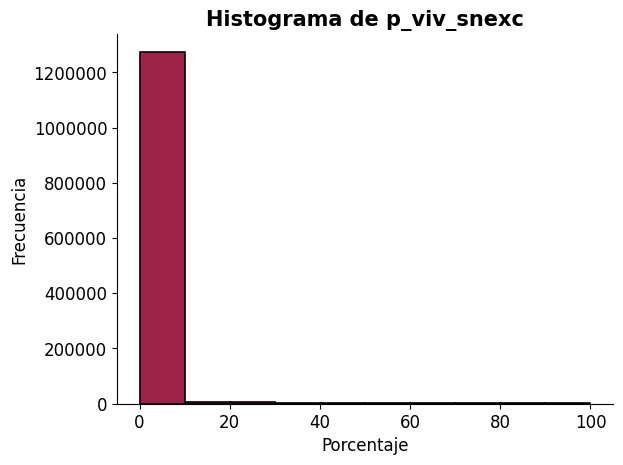

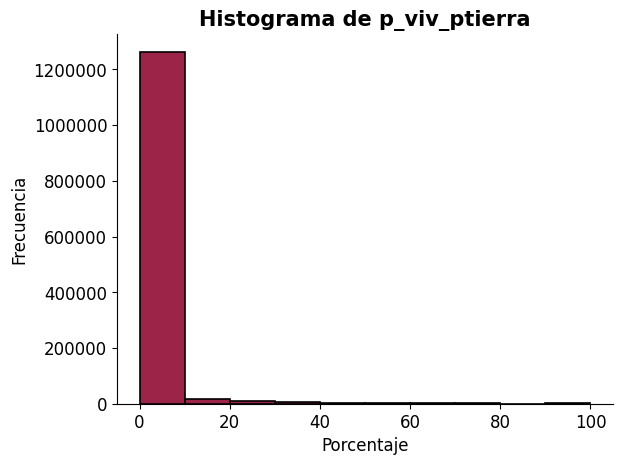

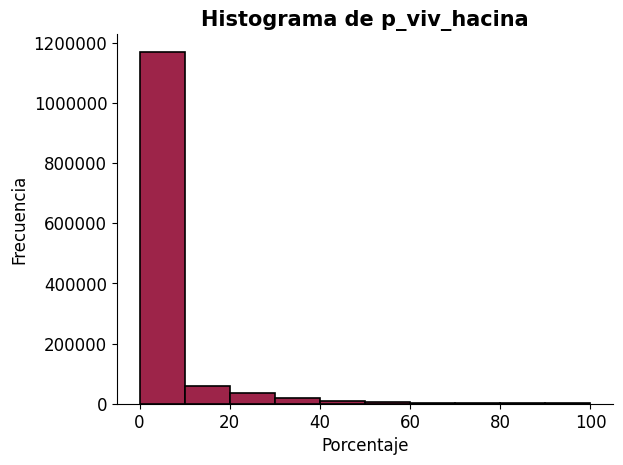

In [13]:
#Histograma de los indicadores
plt.rcParams.update({'font.size': 12})
for indicador in ['p_viv_snexc','p_viv_ptierra','p_viv_hacina']:
    plt.hist(df_limpia[indicador],bins=10,color='#9d2449',edgecolor='black', linewidth=1.2)
    plt.title("Histograma de "+indicador,fontsize=15,fontweight='bold')
    #Evitar que eje y tenga notación científica
    plt.ticklabel_format(style='plain', axis='y')
    plt.xlabel("Porcentaje")
    plt.ylabel("Frecuencia")
    #Eliminar bordes
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)

    plt.show()

In [14]:
#Suma de viviendas con pisos de tierra, sin excusado y en hacinamiento
print("El número de viviendas con pisos de tierra es "+str("{:,}".format(df_limpia['vph_pisoti'].sum())))
print("El número de viviendas sin excusado es "+str("{:,}".format(df_limpia['vph_letr'].sum())))
print("El número de viviendas en hacinamiento es "+str("{:,}".format(df_limpia['vph_1cuart'].sum()+df_limpia['vph_2cuart'].sum())))
#Total de viviendas particulares habitadas
print("El número de viviendas particulares habitadas es "+str("{:,}".format(df_limpia['tvivparhab'].sum())))

El número de viviendas con pisos de tierra es 287,872.0
El número de viviendas sin excusado es 223,513.0
El número de viviendas en hacinamiento es 4,354,002.0
El número de viviendas particulares habitadas es 28,294,729.0


## Cálculo de componentes principales para crear índice

In [15]:
dato_pca=df_limpia[['p_viv_snexc','p_viv_ptierra','p_viv_hacina']]
#Crear objeto PCA
pca = PCA(n_components=3)
#Entrenar PCA
data=pca.fit_transform(dato_pca)

[0.48112607 0.3425365  0.17633744]


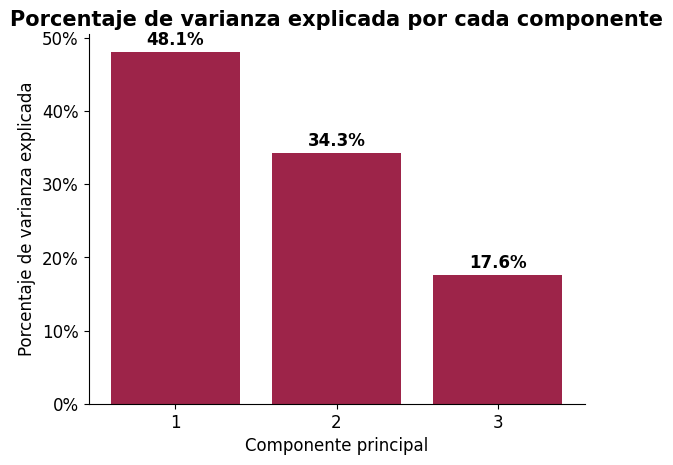

In [16]:
#Porcentaje de varianza explicada por cada componente
print(pca.explained_variance_ratio_)
#Gráfica de barras de varianza explicada
plt.bar(range(1,4),pca.explained_variance_ratio_,color='#9d2449',align='center')
plt.title('Porcentaje de varianza explicada por cada componente', fontsize=15, fontweight='bold')
plt.xlabel('Componente principal')
plt.ylabel('Porcentaje de varianza explicada')
plt.xticks(range(1,4))
#etiquetas en la parte superior de las barras
for x,y in zip(range(1,4),pca.explained_variance_ratio_):
    plt.text(x,y+0.01,str(round(y*100,1))+'%',color='black',ha='center',fontweight='bold')
    #Eje y multiplicado por 100
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
#Eliminar borde derecho y superior
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.show()


In [17]:
#Suma de la varianza explicada por los componenntes 1 y 2   
print("La suma de la varianza explicada por los componentes 1 y 2 es "+str(round(pca.explained_variance_ratio_[0]+pca.explained_variance_ratio_[1],3)))

La suma de la varianza explicada por los componentes 1 y 2 es 0.824


In [18]:
#Crear un índice de rezago habitacional con base en el primer y segundo componente principal
ind1=data[:,0]
ind2=data[:,1]
explained_variance=pca.explained_variance_ratio_
ind_rez=ind1*explained_variance[0]+ind2*explained_variance[1]
#Normalizar el índice de rezago habitacional
ind_rez=(ind_rez-ind_rez.min())/(ind_rez.max()-ind_rez.min())


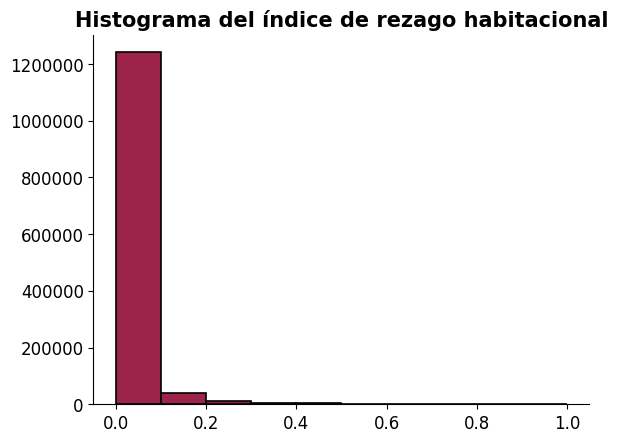

In [19]:
#Graficar el índice de rezago habitacional
plt.hist(ind_rez,bins=10,edgecolor='black', linewidth=1.2, color='#9d2449')
plt.title("Histograma del índice de rezago habitacional",fontsize=15, fontweight='bold')
#Evitar que eje y tenga notación científica
plt.ticklabel_format(style='plain', axis='y')
#Eliminar borde derecho y superior
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.show()

In [20]:
#Agregar el índice de rezago habitacional al dataframe
df_limpia['ind_rez']=ind_rez

In [21]:
df_limpia

,entidad,nom_ent,mun,nom_mun,loc,nom_loc,ageb,mza,vivtot,tvivhab,...,vph_cvj,vph_sinrtv,vph_sinltc,vph_sincint,vph_sintic,cvegeo,p_viv_snexc,p_viv_ptierra,p_viv_hacina,ind_rez
4,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,0017,1,82,54.0,...,5.0,0.0,0.0,36.0,0.0,1.001000e+14,0.0,0.0,0.0,5.220967e-12
5,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,0017,2,83,52.0,...,5.0,0.0,0.0,31.0,0.0,1.001000e+14,0.0,0.0,0.0,0.000000e+00
6,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,0017,3,84,55.0,...,5.0,4.0,0.0,35.0,0.0,1.001000e+14,0.0,0.0,0.0,4.432311e-13
7,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,0017,4,84,57.0,...,5.0,0.0,0.0,33.0,0.0,1.001000e+14,0.0,0.0,0.0,4.427050e-13
8,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,0017,5,68,48.0,...,6.0,0.0,3.0,22.0,0.0,1.001000e+14,0.0,0.0,0.0,4.427050e-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33828,32,Zacatecas,58,Santa María de la Paz,1,Santa María de la Paz,0123,7,8,6.0,...,0.0,0.0,0.0,4.0,0.0,3.205800e+15,0.0,0.0,0.0,4.427050e-13
33831,32,Zacatecas,58,Santa María de la Paz,1,Santa María de la Paz,0123,10,6,4.0,...,0.0,0.0,0.0,0.0,0.0,3.205800e+15,0.0,0.0,0.0,4.427050e-13
33834,32,Zacatecas,58,Santa María de la Paz,1,Santa María de la Paz,0123,13,13,11.0,...,0.0,0.0,0.0,9.0,0.0,3.205800e+15,0.0,0.0,0.0,4.427050e-13
33838,32,Zacatecas,58,Santa María de la Paz,1,Santa María de la Paz,0123,17,5,3.0,...,0.0,0.0,0.0,3.0,0.0,3.205800e+15,0.0,0.0,0.0,4.427050e-13


In [22]:
#Obtener 30 primeros registros con mayor rezago habitacional. Mostrar entidad, nom_ent, mun, nom_mun, lc, nom_loc, ind_rez
df_limpia.sort_values(by='ind_rez',ascending=False).head(60)[['entidad','nom_ent','mun','nom_mun','loc','nom_loc','p_viv_snexc','p_viv_ptierra','p_viv_hacina','ind_rez']]

,entidad,nom_ent,mun,nom_mun,loc,nom_loc,p_viv_snexc,p_viv_ptierra,p_viv_hacina,ind_rez
72957,30,Veracruz de Ignacio de la Llave,160,Álamo Temapache,1,Álamo,100.000000,100.000000,100.000000,1.000000
50485,26,Sonora,42,Navojoa,1,Navojoa,100.000000,100.000000,100.000000,1.000000
24832,28,Tamaulipas,22,Matamoros,1,Heroica Matamoros,100.000000,100.000000,100.000000,1.000000
71011,26,Sonora,72,San Ignacio Río Muerto,17,Bahía de Lobos,100.000000,100.000000,100.000000,1.000000
72959,30,Veracruz de Ignacio de la Llave,160,Álamo Temapache,1,Álamo,100.000000,100.000000,100.000000,1.000000
24262,28,Tamaulipas,22,Matamoros,1,Heroica Matamoros,100.000000,100.000000,100.000000,1.000000
42782,26,Sonora,30,Hermosillo,343,Miguel Alemán (La Doce),100.000000,100.000000,100.000000,1.000000
44767,16,Michoacán de Ocampo,66,Pátzcuaro,1,Pátzcuaro,100.000000,100.000000,100.000000,1.000000
62962,30,Veracruz de Ignacio de la Llave,131,Poza Rica de Hidalgo,1,Poza Rica de Hidalgo,100.000000,100.000000,100.000000,1.000000
44418,26,Sonora,33,Huatabampo,1,Huatabampo,100.000000,100.000000,100.000000,1.000000


In [23]:
#Obtener 30 primeros registros con mayor rezago habitacional. Mostrar entidad, nom_ent, mun, nom_mun, lc, nom_loc, ind_rez
df_limpia[(df_limpia['entidad']==20)].sort_values(by='ind_rez',ascending=False).head(30)[['entidad','nom_ent','mun','nom_mun','loc','nom_loc','p_viv_snexc','p_viv_ptierra','p_viv_hacina','ind_rez']]

,entidad,nom_ent,mun,nom_mun,loc,nom_loc,p_viv_snexc,p_viv_ptierra,p_viv_hacina,ind_rez
16757,20,Oaxaca,67,Oaxaca de Juárez,1,Oaxaca de Juárez,80.000000,100.000000,100.000000,0.903964
51345,20,Oaxaca,391,Santa Lucía Miahuatlán,1,Santa Lucía Miahuatlán,100.000000,77.777778,55.555556,0.820980
17592,20,Oaxaca,67,Oaxaca de Juárez,1,Oaxaca de Juárez,100.000000,60.000000,60.000000,0.792073
17604,20,Oaxaca,67,Oaxaca de Juárez,1,Oaxaca de Juárez,100.000000,42.857143,71.428571,0.784611
71537,20,Oaxaca,565,Villa de Zaachila,37,Ninguno,100.000000,0.000000,100.000000,0.765957
17596,20,Oaxaca,67,Oaxaca de Juárez,1,Oaxaca de Juárez,100.000000,0.000000,100.000000,0.765957
21339,20,Oaxaca,81,San Agustín Atenango,1,San Agustín Atenango,100.000000,0.000000,100.000000,0.765957
22668,20,Oaxaca,98,San Andrés Teotilálpam,1,San Andrés Teotilálpam,100.000000,0.000000,100.000000,0.765957
71726,20,Oaxaca,565,Villa de Zaachila,37,Ninguno,65.517241,86.206897,79.310345,0.743012
22672,20,Oaxaca,98,San Andrés Teotilálpam,1,San Andrés Teotilálpam,100.000000,57.894737,42.105263,0.736007


In [24]:
#Contar número de registros de Aguascalientes
df_limpia[(df_limpia['entidad']==1)].shape[0]

13448

In [27]:
#Guardar en csv
df_limpia.to_csv('D:/df_limpia.csv',index=False,columns=['cvegeo','entidad','nom_ent','mun','nom_mun','loc','nom_loc','mza','p_viv_snexc','p_viv_ptierra','p_viv_hacina','ind_rez'])